# Requirement 4

FUNCTION DEFINITION AND CORE

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from bidding_agents import MultiplicativePacingAgent as PrimalDualTruthful
from bidding_agents import FFMultiplicativePacingAgent as PrimalDualNonTruthful
from bidding_agents import ucblike as UCB
import pandas as pd 


class FirstPriceAuction:
    def __init__(self, num_bidders):
        self.ctrs = np.ones(num_bidders) 
        self.n_adv = len(self.ctrs)

    def round(self, bids):
        winners, values = self.get_winners(bids) # Allocation mechanism
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

def simulate_auction(num_bidders, budget, T, eta, valuation, bids_set, epochs=10):

    # Initialize the auction environment
    auction = FirstPriceAuction(num_bidders)

    class_instances = {
        'truthful_bidder': [],
        'non_truthful_bidder': [],
        'ucb_bidder': []
    }

    for i in range(num_bidders):
        if i % 3 == 0:
            class_instances['truthful_bidder'].append(PrimalDualTruthful(valuation, budget, T, eta))
        elif i % 3 == 1:
            class_instances['non_truthful_bidder'].append(PrimalDualNonTruthful(bids_set, valuation, budget, T, eta))
        else:
            class_instances['ucb_bidder'].append(UCB(budget, T, 1, valuation, discretization=20, range=0.1))

    all_payments_t = {i: np.array([]) for i in range(len(class_instances['truthful_bidder']))}
    all_payments_nt = {i: np.array([]) for i in range(len(class_instances['non_truthful_bidder']))}
    all_payments_ucb = {i: np.array([]) for i in range(len(class_instances['ucb_bidder']))}
    all_utilities_t = {i: np.array([]) for i in range(len(class_instances['truthful_bidder']))}
    all_utilities_nt = {i: np.array([]) for i in range(len(class_instances['non_truthful_bidder']))}
    all_utilities_ucb = {i: np.array([]) for i in range(len(class_instances['ucb_bidder']))}
    all_bids_won_t = {i: np.array([]) for i in range(len(class_instances['truthful_bidder']))}
    all_bids_won_nt = {i: np.array([]) for i in range(len(class_instances['non_truthful_bidder']))}
    all_bids_won_ucb = {i: np.array([]) for i in range(len(class_instances['ucb_bidder']))}

    for epoch in range(epochs):

        payments_t = {i: np.array([]) for i in range(len(class_instances['truthful_bidder']))}
        payments_nt = {i: np.array([]) for i in range(len(class_instances['non_truthful_bidder']))}
        payments_ucb = {i: np.array([]) for i in range(len(class_instances['ucb_bidder']))}
        utilities_t = {i: np.array([]) for i in range(len(class_instances['truthful_bidder']))}
        utilities_nt = {i: np.array([]) for i in range(len(class_instances['non_truthful_bidder']))}
        utilities_ucb = {i: np.array([]) for i in range(len(class_instances['ucb_bidder']))}
        bids_won_t = {i: np.array([]) for i in range(len(class_instances['truthful_bidder']))}
        bids_won_nt = {i: np.array([]) for i in range(len(class_instances['non_truthful_bidder']))}
        bids_won_ucb = {i: np.array([]) for i in range(len(class_instances['ucb_bidder']))}
        
        # Run the auction for the specified number of rounds
        np.random.seed(epoch)
        for t in range(T):
            bids_truthful = [instance.bid() for instance in class_instances['truthful_bidder']]
            bids_non_truthful = [instance.bid() for instance in class_instances['non_truthful_bidder']]
            bids_ucb = [instance.bid() for instance in class_instances['ucb_bidder']]

            bids = np.hstack((bids_truthful, bids_non_truthful, bids_ucb))
            
            winners, payments_per_click = auction.round(bids=bids)

            if isinstance(winners, (int, np.integer)):
                winners = [winners]

            # Update algorithms with the reward and store data
            
            for i, truthful_instance in enumerate(class_instances["truthful_bidder"]):
                other_truthful_bids = [bid for j, bid in enumerate(bids_truthful) if j != i]
                other_bids = np.hstack((other_truthful_bids, bids_non_truthful, bids_ucb))
                truthful_bid_index = i
                my_win = int(truthful_bid_index in winners)
                bids_won_t[i] = np.append(bids_won_t[i], my_win)
                m_t = other_bids.max(axis=0)
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                truthful_instance.update(f_t, c_t)
                utilities_t[i] = np.append(utilities_t[i], f_t)

            for i, non_truthful_instance in enumerate(class_instances["non_truthful_bidder"]):
                other_non_truthful_bids = [bid for j, bid in enumerate(bids_non_truthful) if j != i]
                other_bids = np.hstack((bids_truthful, other_non_truthful_bids, bids_ucb))
                non_truthful_bid_index = len(bids_truthful) + i
                my_win = int(non_truthful_bid_index in winners)
                bids_won_nt[i] = np.append(bids_won_nt[i], my_win)
                m_t = other_bids.max()
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                non_truthful_instance.update(f_t, c_t, m_t)
                utilities_nt[i] = np.append(utilities_nt[i], f_t)

            for i, ucb_instance in enumerate(class_instances["ucb_bidder"]):
                other_ucb_bids = [bid for j, bid in enumerate(bids_ucb) if j != i]
                other_bids = np.hstack((bids_truthful, bids_non_truthful, other_ucb_bids))
                ucb_bid_index = len(bids_truthful) + len(bids_non_truthful) + i
                my_win = int(ucb_bid_index in winners)
                bids_won_ucb[i] = np.append(bids_won_ucb[i], my_win)
                m_t = other_bids.max()
                f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
                ucb_instance.update(f_t, c_t)
                utilities_ucb[i] = np.append(utilities_ucb[i], f_t)


            # Record payments per each instance
            for i, bid in enumerate(bids_truthful):
                payments_t[i] = np.append(payments_t[i], bid)
            for i, bid in enumerate(bids_non_truthful):
                payments_nt[i] = np.append(payments_nt[i], bid)
            for i, bid in enumerate(bids_ucb):
                payments_ucb[i] = np.append(payments_ucb[i], bid)
        

        # Record payments and utilities and bids won for each epoch
        for i in range(len(class_instances['truthful_bidder'])):
            all_payments_t[i] = np.append(all_payments_t[i],[payments_t[i]])
            all_utilities_t[i] = np.append(all_utilities_t[i], utilities_t[i])
            all_bids_won_t[i] = np.append(all_bids_won_t[i], bids_won_t[i])
        for i in range(len(class_instances['non_truthful_bidder'])):
            all_payments_nt[i] = np.append(all_payments_nt[i], payments_nt[i])
            all_utilities_nt[i] = np.append(all_utilities_nt[i], utilities_nt[i])
            all_bids_won_nt[i] = np.append(all_bids_won_nt[i], bids_won_nt[i])
        for i in range(len(class_instances['ucb_bidder'])):
            all_payments_ucb[i] = np.append(all_payments_ucb[i], payments_ucb[i])
            all_utilities_ucb[i] = np.append(all_utilities_ucb[i], utilities_ucb[i])
            all_bids_won_ucb[i] = np.append(all_bids_won_ucb[i], bids_won_ucb[i])

    for i in range(len(class_instances['truthful_bidder'])):
        avg_payments_t = {i: np.mean(all_payments_t[i]) for i in all_payments_t}
        avg_utilities_t = {i: np.mean(all_utilities_t[i]) for i in all_utilities_t}
        avg_bids_won_t = {i: np.mean(all_bids_won_t[i]) for i in all_bids_won_t}
    for i in range(len(class_instances['non_truthful_bidder'])):
        avg_payments_nt = {i: np.mean(all_payments_nt[i]) for i in all_payments_nt}
        avg_utilities_nt = {i: np.mean(all_utilities_nt[i]) for i in all_utilities_nt}
        avg_bids_won_nt = {i: np.mean(all_bids_won_nt[i]) for i in all_bids_won_nt}
    for i in range(len(class_instances['ucb_bidder'])):         
        avg_payments_ucb = {i: np.mean(all_payments_ucb[i]) for i in all_payments_ucb}
        avg_utilities_ucb = {i: np.mean(all_utilities_ucb[i]) for i in all_utilities_ucb}
        avg_bids_won_ucb = {i: np.mean(all_bids_won_ucb[i]) for i in all_bids_won_ucb}        
    
    return avg_payments_t, avg_payments_nt, avg_payments_ucb, avg_utilities_t, avg_utilities_nt, avg_utilities_ucb, avg_bids_won_t, avg_bids_won_nt, avg_bids_won_ucb



# Set parameters and run the simulation

num_bidders = 6 # this number can be changed to whatever you want, we modeled the algorithm so that the type of bidder is assigned round robin
B = 130
T = 1000
eta = 1/np.sqrt(T)
my_valuation = 0.6
available_bids = np.linspace(0,1,11)

payments_t, payments_nt, payments_ucb, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Compute the cumulative payments

cumulative_payments_truthful = {i: np.cumsum(payments_t[i]) for i in payments_t}
cumulative_payments_non_truthful = {i: np.cumsum(payments_nt[i]) for i in payments_nt}
cumulative_payments_ucb = {i: np.cumsum(payments_ucb[i]) for i in payments_ucb}

cumulative_utilities_t = {i: np.cumsum(utilities_t[i]) for i in utilities_t}
cumulative_utilities_nt = {i: np.cumsum(utilities_nt[i]) for i in utilities_nt}
cumulative_utilities_ucb = {i: np.cumsum(utilities_ucb[i]) for i in utilities_ucb}

cumulative_bids_won_truthful = {i: np.cumsum(bids_won_t[i]) for i in bids_won_t}
cumulative_bids_won_non_truthful = {i: np.cumsum(bids_won_nt[i]) for i in bids_won_nt}
cumulative_bids_won_ucb = {i: np.cumsum(bids_won_ucb[i]) for i in bids_won_ucb}

# Main payments 

In [80]:
final_cumulative_payments_truthful = {i: np.sum(payments_t[i]) for i in payments_t}
final_cumulative_payments_non_truthful = {i: np.sum(payments_nt[i]) for i in payments_nt}
final_cumulative_payments_ucb = {i: np.sum(payments_ucb[i]) for i in payments_ucb}

final_cumulative_utilities_t = {i: np.sum(utilities_t[i]) for i in utilities_t}
final_cumulative_utilities_nt = {i: np.sum(utilities_nt[i]) for i in utilities_nt}
final_cumulative_utilities_ucb = {i: np.sum(utilities_ucb[i]) for i in utilities_ucb}

final_cumulative_bids_won_truthful = {i: np.sum(bids_won_t[i]) for i in bids_won_t}
final_cumulative_bids_won_non_truthful = {i: np.sum(bids_won_nt[i]) for i in bids_won_nt}
final_cumulative_bids_won_ucb = {i: np.sum(bids_won_ucb[i]) for i in bids_won_ucb}

data = []

for i in final_cumulative_payments_truthful:
    data.append([
        f'Truthful {i+1}',
        final_cumulative_payments_truthful[i],
        final_cumulative_utilities_t[i],
        final_cumulative_bids_won_truthful[i]
    ])

for i in final_cumulative_payments_non_truthful:
    data.append([
        f'Non-Truthful {i+1}',
        final_cumulative_payments_non_truthful[i],
        final_cumulative_utilities_nt[i],
        final_cumulative_bids_won_non_truthful[i]
    ])

for i in final_cumulative_payments_ucb:
    data.append([
        f'UCB {i+1}',
        final_cumulative_payments_ucb[i],
        final_cumulative_utilities_ucb[i],
        final_cumulative_bids_won_ucb[i]
    ])

df = pd.DataFrame(data, columns=['Bidder', 'Cumulative Payment', 'Cumulative Utility', 'Cumulative Bids Won'])

df = df.sort_values(by=['Bidder']).reset_index(drop=True)

print(df)

           Bidder  Cumulative Payment  Cumulative Utility  Cumulative Bids Won
0  Non-Truthful 1            0.083470            0.117068               0.2130
1  Non-Truthful 2            0.049660            0.011955               0.0415
2      Truthful 1            0.064190            0.001194               0.0235
3      Truthful 2            0.064000            0.001188               0.0235
4           UCB 1            0.048107            0.002452               0.0256
5           UCB 2            0.038349            0.390786               0.6729


# Payments

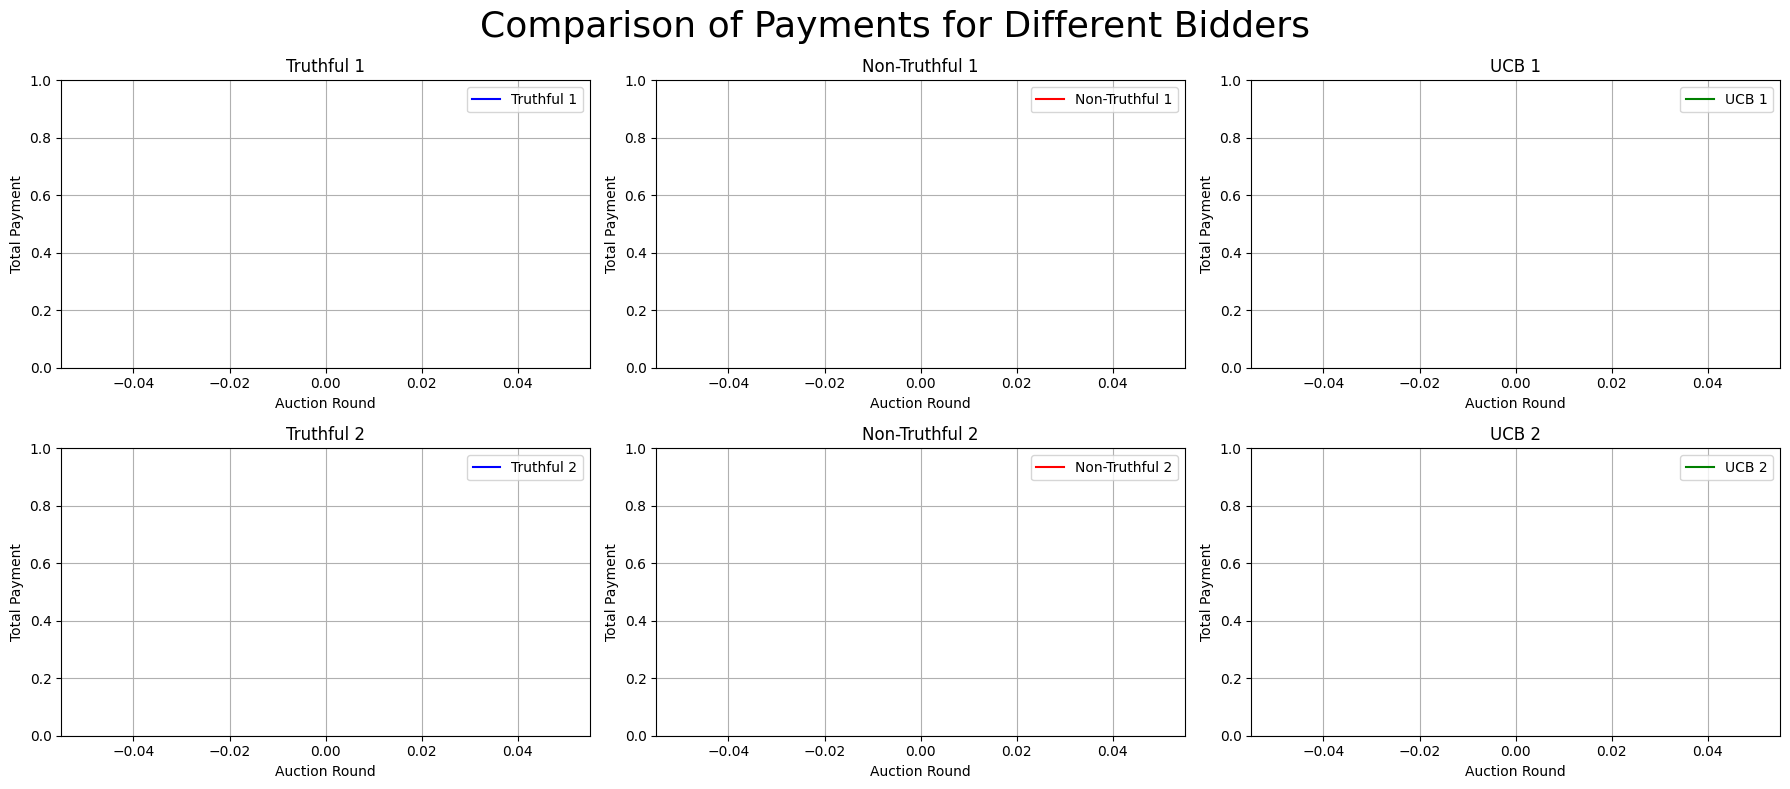

In [81]:
# Plot the payments
total_truthful = len(payments_t)
total_non_truthful = len(payments_nt)
total_ucb = len(payments_ucb)

num_rows = max(total_truthful, total_non_truthful, total_ucb)
num_cols = 3 

fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot payments['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(payments_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Total Payment')
    else:
        ax[row, 0].plot(payments_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Total Payment')

# Plot payments['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(payments_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Total Payment')
    else:
        ax[row, 1].plot(payments_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Total Payment')

# Plot payments['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(payments_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Total Payment')
    else:
        ax[row, 2].plot(payments_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Total Payment')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)
ax[0,0].set_ylim([0,1])
ax[1,0].set_ylim([0,1])
ax[0,1].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
ax[0,2].set_ylim([0,1])
ax[1,2].set_ylim([0,1])
fig.suptitle('Comparison of Payments for Different Bidders', fontsize=26)

plt.tight_layout()
plt.show()

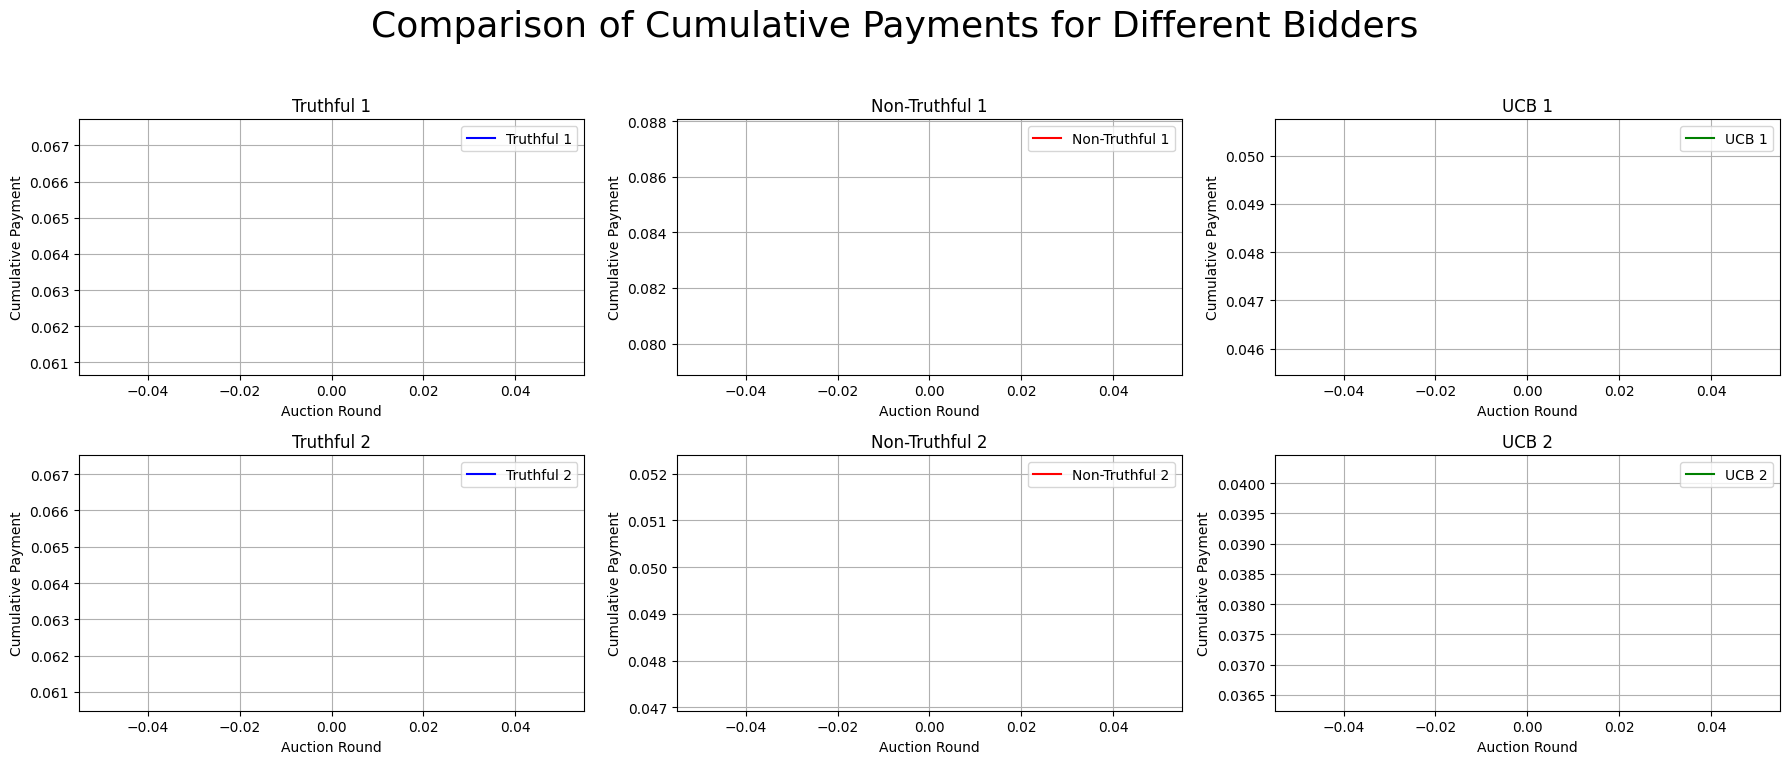

In [82]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot cumulative payments['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(cumulative_payments_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Cumulative Payment')
    else:
        ax[row, 0].plot(cumulative_payments_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Cumulative Payment')

# Plot cumulative payments['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(cumulative_payments_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Cumulative Payment')
    else:
        ax[row, 1].plot(cumulative_payments_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Cumulative Payment')

# Plot cumulative payments['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(cumulative_payments_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Cumulative Payment')
    else:
        ax[row, 2].plot(cumulative_payments_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Cumulative Payment')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Cumulative Payments for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

# Utilities

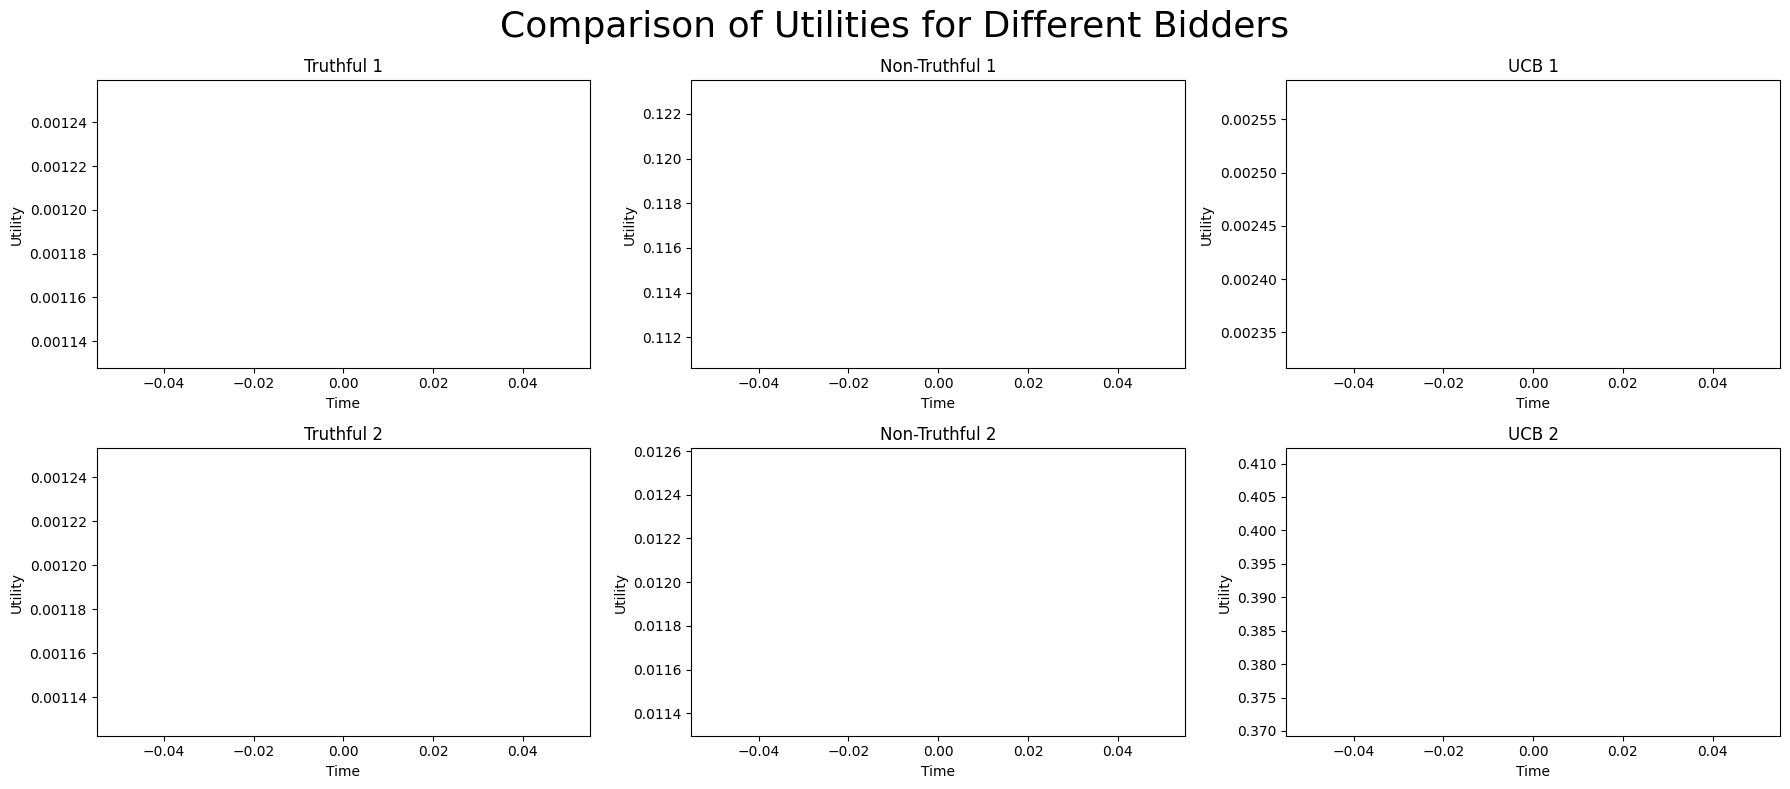

In [83]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot utilities_t
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_ylabel('Utility')
    else:
        ax[row, 0].plot(utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Time')
        ax[row, 0].set_ylabel('Utility')

# Plot utilities_nt
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_ylabel('Utility')
    else:
        ax[row, 1].plot(utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Time')
        ax[row, 1].set_ylabel('Utility')

# Plot utilities_ucb
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Time')
        ax[0, 2].set_ylabel('Utility')
    else:
        ax[row, 2].plot(utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Time')
        ax[row, 2].set_ylabel('Utility')

fig.suptitle('Comparison of Utilities for Different Bidders', fontsize=26)

plt.tight_layout()
plt.show()

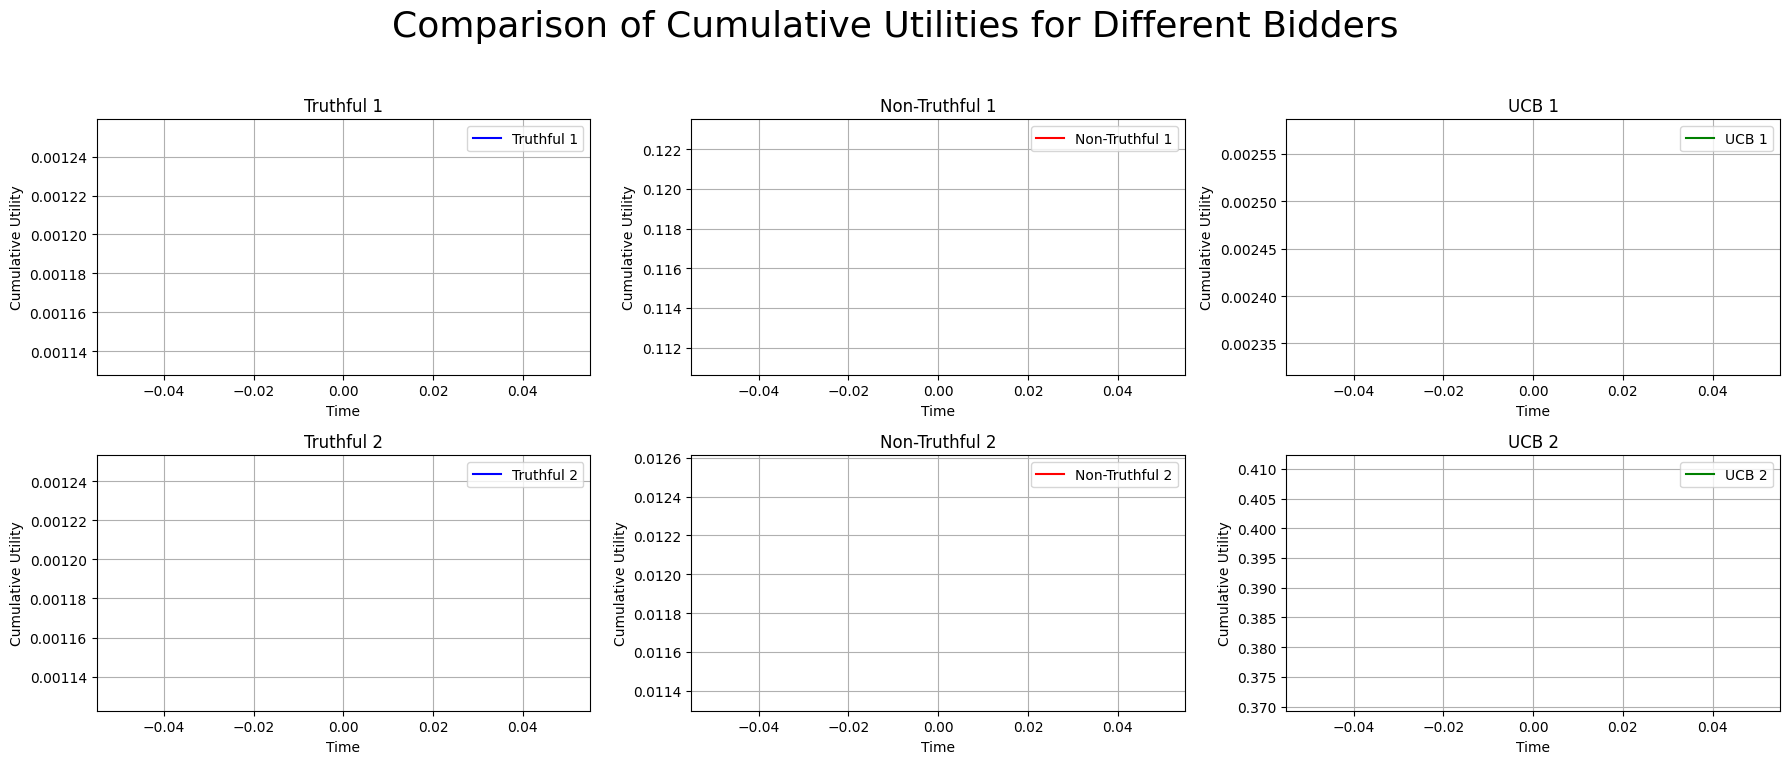

In [84]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot cumulative utilities_t
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(cumulative_utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Time')
        ax[0, 0].set_ylabel('Cumulative Utility')
    else:
        ax[row, 0].plot(cumulative_utilities_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Time')
        ax[row, 0].set_ylabel('Cumulative Utility')

# Plot cumulative utilities_nt
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(cumulative_utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Time')
        ax[0, 1].set_ylabel('Cumulative Utility')
    else:
        ax[row, 1].plot(cumulative_utilities_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Time')
        ax[row, 1].set_ylabel('Cumulative Utility')

# Plot cumulative utilities_ucb
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(cumulative_utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Time')
        ax[0, 2].set_ylabel('Cumulative Utility')
    else:
        ax[row, 2].plot(cumulative_utilities_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Time')
        ax[row, 2].set_ylabel('Cumulative Utility')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Cumulative Utilities for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Bids won 

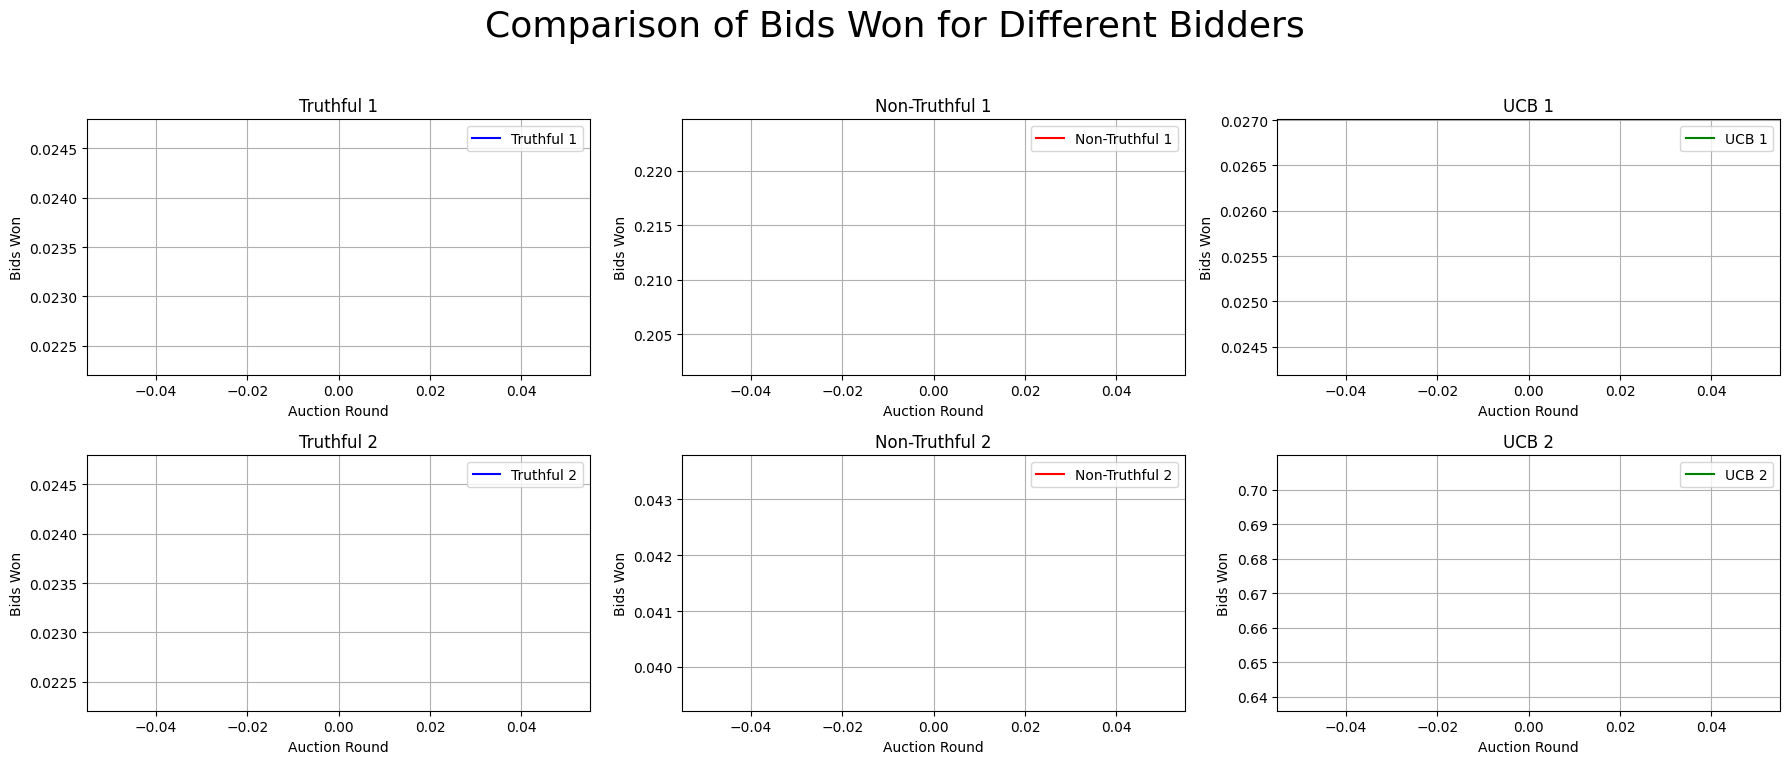

In [85]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot bids_won['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(bids_won_t[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Bids Won')
    else:
        ax[row, 0].plot(bids_won_t[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Bids Won')

# Plot bids_won['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(bids_won_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Bids Won')
    else:
        ax[row, 1].plot(bids_won_nt[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Bids Won')

# Plot bids_won['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Bids Won')
    else:
        ax[row, 2].plot(bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Bids Won')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Bids Won for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

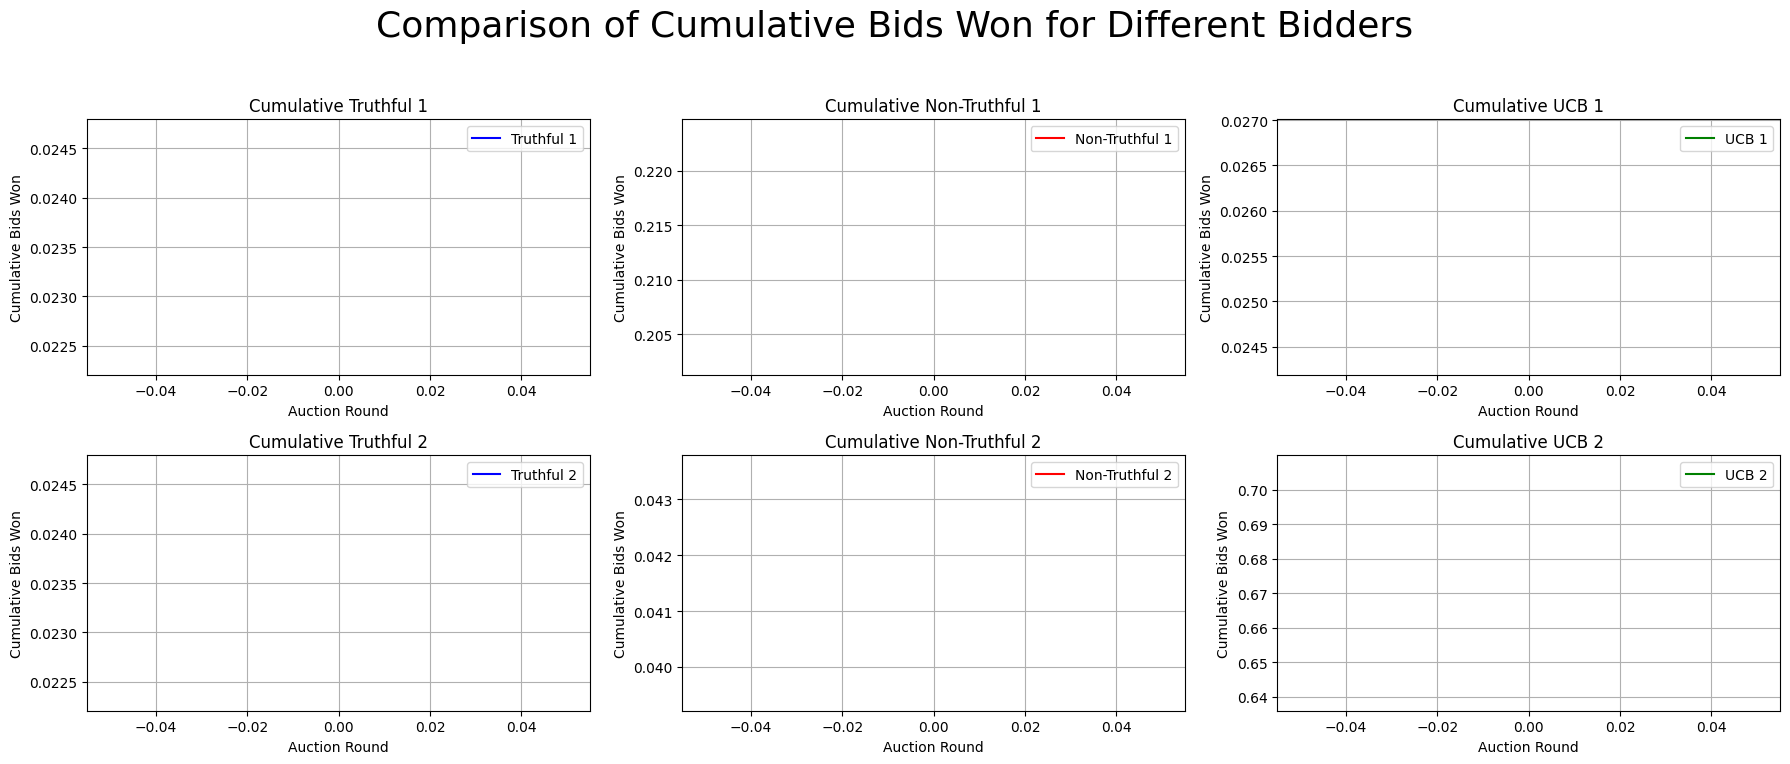

In [86]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

if num_rows == 1 and num_cols == 1:
    ax = np.array([ax])  
elif num_rows == 1:
    ax = np.expand_dims(ax, axis=0)
elif num_cols == 1:
    ax = np.expand_dims(ax, axis=1)

# Plot cumulative bids_won['truthful']
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0, 0].plot(cumulative_bids_won_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[0, 0].set_title(f'Cumulative Truthful {i+1}')
        ax[0, 0].set_xlabel('Auction Round')
        ax[0, 0].set_ylabel('Cumulative Bids Won')
    else:
        ax[row, 0].plot(cumulative_bids_won_truthful[i], label=f'Truthful {i+1}', color='blue')
        ax[row, 0].set_title(f'Cumulative Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Cumulative Bids Won')

# Plot cumulative bids_won['non_truthful']
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[0, 1].plot(cumulative_bids_won_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[0, 1].set_title(f'Cumulative Non-Truthful {i+1}')
        ax[0, 1].set_xlabel('Auction Round')
        ax[0, 1].set_ylabel('Cumulative Bids Won')
    else:
        ax[row, 1].plot(cumulative_bids_won_non_truthful[i], label=f'Non-Truthful {i+1}', color='red')
        ax[row, 1].set_title(f'Cumulative Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Cumulative Bids Won')

# Plot cumulative bids_won['ucb']
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[0, 2].plot(cumulative_bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[0, 2].set_title(f'Cumulative UCB {i+1}')
        ax[0, 2].set_xlabel('Auction Round')
        ax[0, 2].set_ylabel('Cumulative Bids Won')
    else:
        ax[row, 2].plot(cumulative_bids_won_ucb[i], label=f'UCB {i+1}', color='green')
        ax[row, 2].set_title(f'Cumulative UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Cumulative Bids Won')

for col in range(num_cols):
    for row in range(num_rows):
        if num_rows > 1 or num_cols > 1:
            ax[row, col].legend()
            ax[row, col].grid(True)
        else:
            ax[col].legend()
            ax[col].grid(True)

fig.suptitle('Comparison of Cumulative Bids Won for Different Bidders', fontsize=26)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
plt.show()

# Changing Parameters

CHANGING my_valuation 

In [87]:
num_bidders = 6 
B = 130
T = 1000
eta = 1/np.sqrt(T)
my_valuation = 0.4
available_bids = np.linspace(0,1,11)

payments_t, payments_nt, payments_ucb, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Compute the cumulative payments

cumulative_payments_truthful = {i: np.cumsum(payments_t[i]) for i in payments_t}
cumulative_payments_non_truthful = {i: np.cumsum(payments_nt[i]) for i in payments_nt}
cumulative_payments_ucb = {i: np.cumsum(payments_ucb[i]) for i in payments_ucb}

cumulative_utilities_t = {i: np.cumsum(utilities_t[i]) for i in utilities_t}
cumulative_utilities_nt = {i: np.cumsum(utilities_nt[i]) for i in utilities_nt}
cumulative_utilities_ucb = {i: np.cumsum(utilities_ucb[i]) for i in utilities_ucb}

cumulative_bids_won_truthful = {i: np.cumsum(bids_won_t[i]) for i in bids_won_t}
cumulative_bids_won_non_truthful = {i: np.cumsum(bids_won_nt[i]) for i in bids_won_nt}
cumulative_bids_won_ucb = {i: np.cumsum(bids_won_ucb[i]) for i in bids_won_ucb}

In [88]:
final_cumulative_payments_truthful = {i: np.sum(payments_t[i]) for i in payments_t}
final_cumulative_payments_non_truthful = {i: np.sum(payments_nt[i]) for i in payments_nt}
final_cumulative_payments_ucb = {i: np.sum(payments_ucb[i]) for i in payments_ucb}

final_cumulative_utilities_t = {i: np.sum(utilities_t[i]) for i in utilities_t}
final_cumulative_utilities_nt = {i: np.sum(utilities_nt[i]) for i in utilities_nt}
final_cumulative_utilities_ucb = {i: np.sum(utilities_ucb[i]) for i in utilities_ucb}

final_cumulative_bids_won_truthful = {i: np.sum(bids_won_t[i]) for i in bids_won_t}
final_cumulative_bids_won_non_truthful = {i: np.sum(bids_won_nt[i]) for i in bids_won_nt}
final_cumulative_bids_won_ucb = {i: np.sum(bids_won_ucb[i]) for i in bids_won_ucb}

data = []

for i in final_cumulative_payments_truthful:
    data.append([
        f'Truthful {i+1}',
        final_cumulative_payments_truthful[i],
        final_cumulative_utilities_t[i],
        final_cumulative_bids_won_truthful[i]
    ])

for i in final_cumulative_payments_non_truthful:
    data.append([
        f'Non-Truthful {i+1}',
        final_cumulative_payments_non_truthful[i],
        final_cumulative_utilities_nt[i],
        final_cumulative_bids_won_non_truthful[i]
    ])

for i in final_cumulative_payments_ucb:
    data.append([
        f'UCB {i+1}',
        final_cumulative_payments_ucb[i],
        final_cumulative_utilities_ucb[i],
        final_cumulative_bids_won_ucb[i]
    ])

df = pd.DataFrame(data, columns=['Bidder', 'Cumulative Payment', 'Cumulative Utility', 'Cumulative Bids Won'])

df = df.sort_values(by=['Bidder']).reset_index(drop=True)

print(df)

           Bidder  Cumulative Payment  Cumulative Utility  Cumulative Bids Won
0  Non-Truthful 1            0.077290            0.071510               0.2102
1  Non-Truthful 2            0.049460            0.005617               0.0463
2      Truthful 1            0.048728            0.000615               0.0338
3      Truthful 2            0.047611            0.000499               0.0335
4           UCB 1            0.045082            0.001765               0.0367
5           UCB 2            0.054476            0.242894               0.6395


CHANGING eta

In [89]:
num_bidders = 6 
B = 130
T = 1000
eta = 0.1
my_valuation = 0.4
available_bids = np.linspace(0,1,11)

payments_t, payments_nt, payments_ucb, utilities_t, utilities_nt, utilities_ucb, bids_won_t, bids_won_nt, bids_won_ucb = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Compute the cumulative payments

cumulative_payments_truthful = {i: np.cumsum(payments_t[i]) for i in payments_t}
cumulative_payments_non_truthful = {i: np.cumsum(payments_nt[i]) for i in payments_nt}
cumulative_payments_ucb = {i: np.cumsum(payments_ucb[i]) for i in payments_ucb}

cumulative_utilities_t = {i: np.cumsum(utilities_t[i]) for i in utilities_t}
cumulative_utilities_nt = {i: np.cumsum(utilities_nt[i]) for i in utilities_nt}
cumulative_utilities_ucb = {i: np.cumsum(utilities_ucb[i]) for i in utilities_ucb}

cumulative_bids_won_truthful = {i: np.cumsum(bids_won_t[i]) for i in bids_won_t}
cumulative_bids_won_non_truthful = {i: np.cumsum(bids_won_nt[i]) for i in bids_won_nt}
cumulative_bids_won_ucb = {i: np.cumsum(bids_won_ucb[i]) for i in bids_won_ucb}

In [90]:
final_cumulative_payments_truthful = {i: np.sum(payments_t[i]) for i in payments_t}
final_cumulative_payments_non_truthful = {i: np.sum(payments_nt[i]) for i in payments_nt}
final_cumulative_payments_ucb = {i: np.sum(payments_ucb[i]) for i in payments_ucb}

final_cumulative_utilities_t = {i: np.sum(utilities_t[i]) for i in utilities_t}
final_cumulative_utilities_nt = {i: np.sum(utilities_nt[i]) for i in utilities_nt}
final_cumulative_utilities_ucb = {i: np.sum(utilities_ucb[i]) for i in utilities_ucb}

final_cumulative_bids_won_truthful = {i: np.sum(bids_won_t[i]) for i in bids_won_t}
final_cumulative_bids_won_non_truthful = {i: np.sum(bids_won_nt[i]) for i in bids_won_nt}
final_cumulative_bids_won_ucb = {i: np.sum(bids_won_ucb[i]) for i in bids_won_ucb}

data = []

for i in final_cumulative_payments_truthful:
    data.append([
        f'Truthful {i+1}',
        final_cumulative_payments_truthful[i],
        final_cumulative_utilities_t[i],
        final_cumulative_bids_won_truthful[i]
    ])

for i in final_cumulative_payments_non_truthful:
    data.append([
        f'Non-Truthful {i+1}',
        final_cumulative_payments_non_truthful[i],
        final_cumulative_utilities_nt[i],
        final_cumulative_bids_won_non_truthful[i]
    ])

for i in final_cumulative_payments_ucb:
    data.append([
        f'UCB {i+1}',
        final_cumulative_payments_ucb[i],
        final_cumulative_utilities_ucb[i],
        final_cumulative_bids_won_ucb[i]
    ])

df = pd.DataFrame(data, columns=['Bidder', 'Cumulative Payment', 'Cumulative Utility', 'Cumulative Bids Won'])

df = df.sort_values(by=['Bidder']).reset_index(drop=True)

print(df)

           Bidder  Cumulative Payment  Cumulative Utility  Cumulative Bids Won
0  Non-Truthful 1            0.046140            0.000115               0.0326
1  Non-Truthful 2            0.047000            0.003211               0.0403
2      Truthful 1            0.047745            0.001015               0.0348
3      Truthful 2            0.045433            0.000558               0.0337
4           UCB 1            0.055335            0.005592               0.0463
5           UCB 2            0.147629            0.312754               0.8123
